# Capstone — Initial Report & Exploratory Data Analysis (EDA)

**Research question:** How can AI-driven analysis of telehealth & nutrition data improve patient outcomes and product personalization (Skinii® ecosystem)?

**Goal (Module 20.1):** Clean data, perform EDA, engineer features, and build a **baseline model** for comparison in Module 24.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)

sns.set(style="whitegrid")
np.random.seed(42)


In [2]:
# Generate a synthetic Skinii® telehealth dataset and save to CSV
n = 5000
ages = np.random.randint(18, 70, size=n)
bmi = np.round(np.random.normal(27, 5, size=n), 1).clip(16, 55)
activity_level = np.random.choice(["low", "moderate", "high"], size=n, p=[0.3, 0.5, 0.2])
diet_type = np.random.choice(["balanced", "low-carb", "high-protein", "vegetarian"], size=n)
glp1_use = np.random.choice(["yes", "no"], size=n, p=[0.4, 0.6])
weekly_checkins = np.random.randint(0, 5, size=n)
water_intake = np.round(np.random.normal(2.5, 0.7, size=n), 1).clip(0.5, 6.0)  # liters/day
sleep_hours = np.round(np.random.normal(6.8, 1.2, size=n), 1).clip(3.0, 11.0)
stress_level = np.random.choice(["low", "moderate", "high"], size=n, p=[0.4, 0.4, 0.2])

# Outcome function (probability-style, then threshold)
score = (
    (28 - bmi)/6.0 +                      # lower BMI helps
    (np.array(activity_level) == "high")*0.8 +
    (np.array(activity_level) == "moderate")*0.3 +
    (np.array(glp1_use) == "yes")*0.6 +
    (sleep_hours - 7.0)/3.0 +
    (water_intake - 2.5)/2.5 -
    (np.array(stress_level) == "high")*0.6
)
prob = 1/(1 + np.exp(-score))
outcome = (prob > 0.5).astype(int)

df = pd.DataFrame({
    "age": ages,
    "bmi": bmi,
    "activity_level": activity_level,
    "diet_type": diet_type,
    "glp1_use": glp1_use,
    "weekly_checkins": weekly_checkins,
    "water_intake": water_intake,
    "sleep_hours": sleep_hours,
    "stress_level": stress_level,
    "outcome": outcome
})

df.to_csv("skinii_health_data.csv", index=False)
print("✅ Synthetic Skinii dataset generated & saved:", df.shape)
df.head()


✅ Synthetic Skinii dataset generated & saved: (5000, 10)


,age,bmi,activity_level,diet_type,glp1_use,weekly_checkins,water_intake,sleep_hours,stress_level,outcome
0,56,26.5,moderate,high-protein,no,3,3.0,7.8,moderate,1
1,69,29.5,moderate,vegetarian,no,2,2.5,8.5,high,0
2,46,25.1,low,low-carb,no,1,2.5,7.5,moderate,1
3,32,29.1,low,balanced,yes,4,1.9,8.2,moderate,1
4,60,22.7,high,vegetarian,no,3,2.9,7.4,low,1


In [3]:
# Reload from CSV (treat it like a real sourced dataset)
df = pd.read_csv("skinii_health_data.csv")
print(df.shape)
df.head()


(5000, 10)


,age,bmi,activity_level,diet_type,glp1_use,weekly_checkins,water_intake,sleep_hours,stress_level,outcome
0,56,26.5,moderate,high-protein,no,3,3.0,7.8,moderate,1
1,69,29.5,moderate,vegetarian,no,2,2.5,8.5,high,0
2,46,25.1,low,low-carb,no,1,2.5,7.5,moderate,1
3,32,29.1,low,balanced,yes,4,1.9,8.2,moderate,1
4,60,22.7,high,vegetarian,no,3,2.9,7.4,low,1


In [5]:
# Structure, types, basic stats, and missing values (version-safe)

# .info() prints to stdout; don't wrap in display()
df.info()

# Numeric-only describe (works across pandas versions)
num_desc = df.select_dtypes(include=[np.number]).describe().T
display(num_desc)

# Missing values per column
missing = df.isna().sum().to_frame("missing_count")
display(missing)

# Outcome distribution (counts and percent)
outcome_counts = df["outcome"].value_counts().to_frame("count")
outcome_counts["percent"] = (outcome_counts["count"] / len(df)).round(3)
display(outcome_counts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              5000 non-null   int64  
 1   bmi              5000 non-null   float64
 2   activity_level   5000 non-null   object 
 3   diet_type        5000 non-null   object 
 4   glp1_use         5000 non-null   object 
 5   weekly_checkins  5000 non-null   int64  
 6   water_intake     5000 non-null   float64
 7   sleep_hours      5000 non-null   float64
 8   stress_level     5000 non-null   object 
 9   outcome          5000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 390.8+ KB


,count,mean,std,min,25%,50%,75%,max
age,5000.0,43.58460,14.919094,18.0,31.0,43.0,56.0,69.0
bmi,5000.0,26.94270,4.966368,16.0,23.5,26.9,30.3,43.4
weekly_checkins,5000.0,2.04300,1.418010,0.0,1.0,2.0,3.0,4.0
water_intake,5000.0,2.49704,0.695425,0.5,2.0,2.5,3.0,5.2
sleep_hours,5000.0,6.82300,1.187861,3.0,6.0,6.8,7.6,10.9
outcome,5000.0,0.68620,0.464083,0.0,0.0,1.0,1.0,1.0


,missing_count
age,0
bmi,0
activity_level,0
diet_type,0
glp1_use,0
weekly_checkins,0
water_intake,0
sleep_hours,0
stress_level,0
outcome,0


,count,percent
outcome,,
1,3431,0.686
0,1569,0.314


In [6]:
# Remove duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Duplicates removed: {before - after}")

# Simple imputation strategy (in case of any NAs)
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Numeric → fill with mean
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())

# Categorical → fill with mode
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

print("Any NA left?:", df.isna().sum().sum())
df.head(2)


Duplicates removed: 0
Any NA left?: 0


,age,bmi,activity_level,diet_type,glp1_use,weekly_checkins,water_intake,sleep_hours,stress_level,outcome
0,56,26.5,moderate,high-protein,no,3,3.0,7.8,moderate,1
1,69,29.5,moderate,vegetarian,no,2,2.5,8.5,high,0


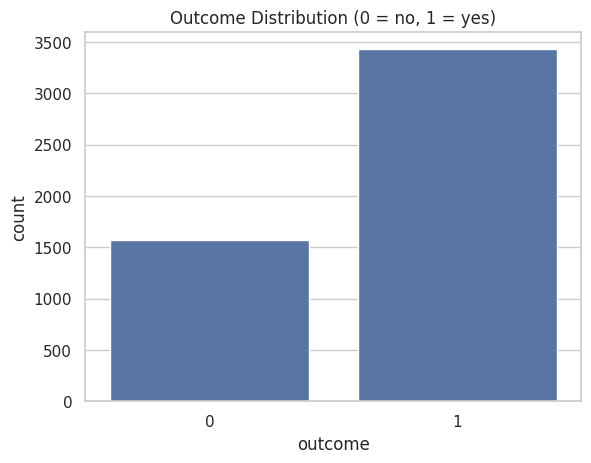

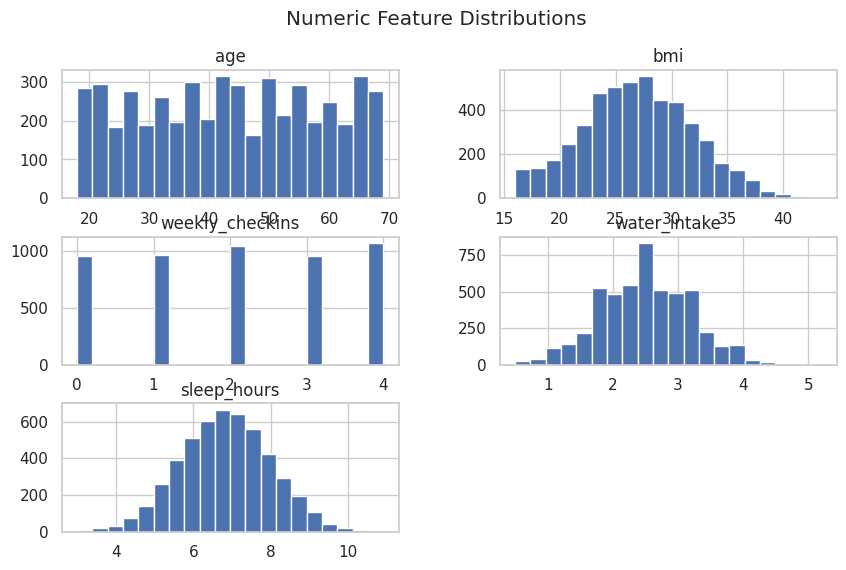

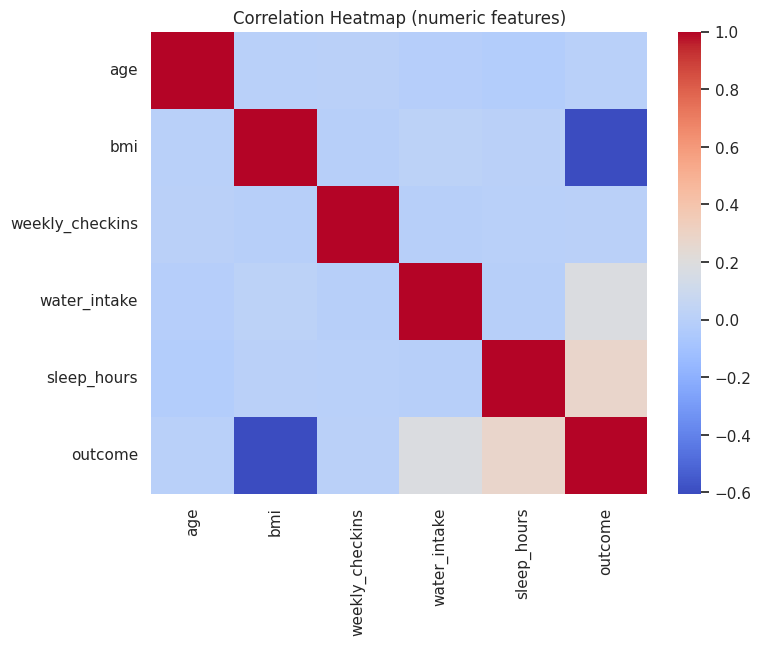

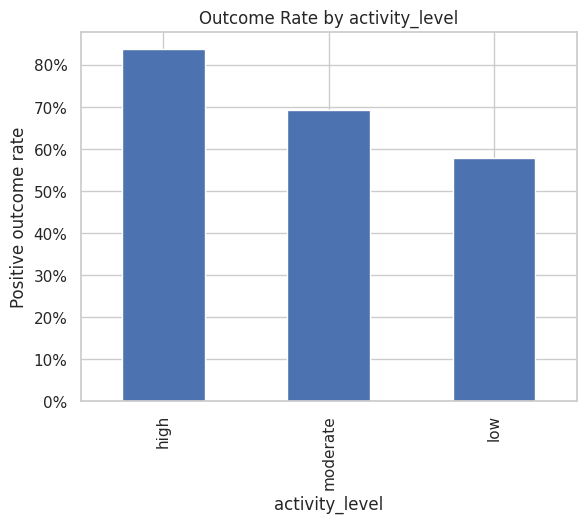

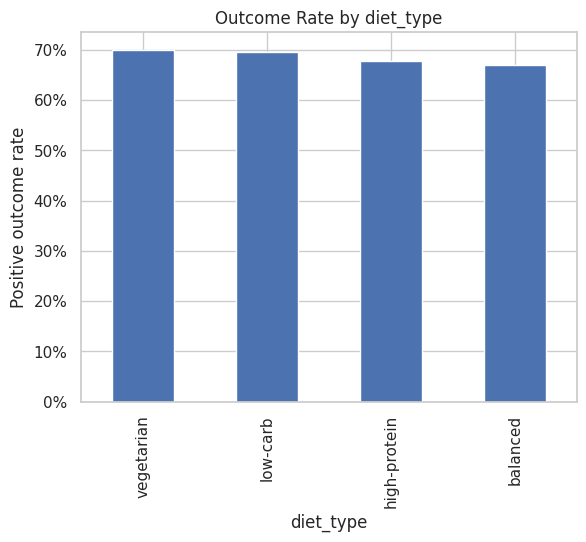

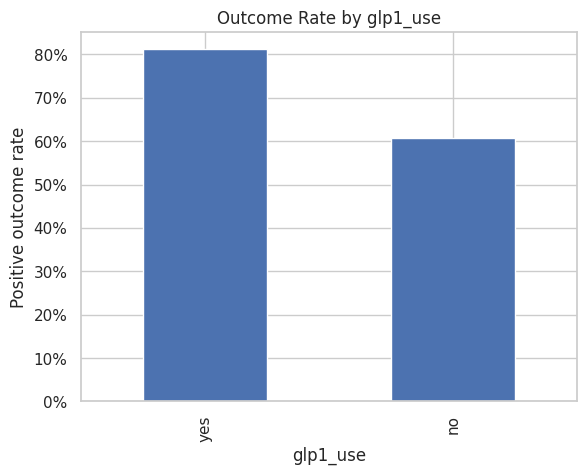

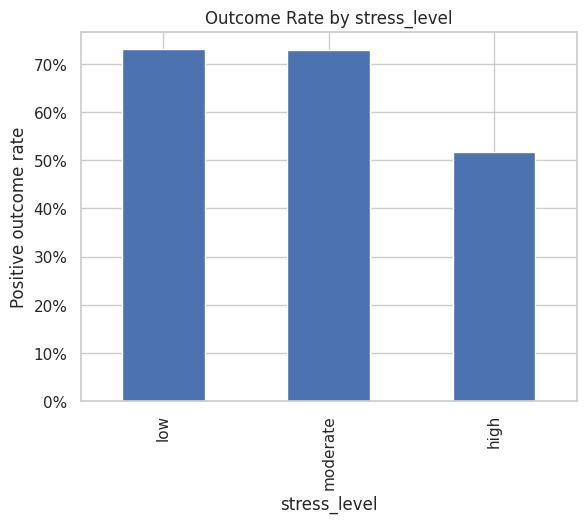

In [7]:
import matplotlib.ticker as mtick

# Target distribution
sns.countplot(x="outcome", data=df)
plt.title("Outcome Distribution (0 = no, 1 = yes)")
plt.show()

# Numeric histograms
num_cols = ["age","bmi","weekly_checkins","water_intake","sleep_hours"]
df[num_cols].hist(figsize=(10,6), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Correlation heatmap (numeric only)
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + ["outcome"]].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features)")
plt.show()

# Categorical vs outcome (rate plots)
cats = ["activity_level","diet_type","glp1_use","stress_level"]
for c in cats:
    rates = df.groupby(c)["outcome"].mean().sort_values(ascending=False)
    ax = rates.plot(kind="bar")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.title(f"Outcome Rate by {c}")
    plt.ylabel("Positive outcome rate")
    plt.xlabel(c)
    plt.show()


In [8]:
# Optional derived features
df["bmi_class"] = pd.cut(
    df["bmi"],
    bins=[0,18.5,25,30,60],
    labels=["underweight","normal","overweight","obese"]
)

# Define X, y (keep raw; encoding happens in pipeline)
y = df["outcome"].astype(int)
X = df.drop(columns=["outcome"])

# Identify columns for preprocessing
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# Preprocess: OneHot for categorical, scale numeric
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="drop"
)


Numeric: ['age', 'bmi', 'weekly_checkins', 'water_intake', 'sleep_hours']
Categorical: ['activity_level', 'diet_type', 'glp1_use', 'stress_level', 'bmi_class']


Accuracy:  0.994
ROC-AUC:   1.000
Precision: 0.994
Recall:    0.997
F1:        0.996

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       314
           1       0.99      1.00      1.00       686

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



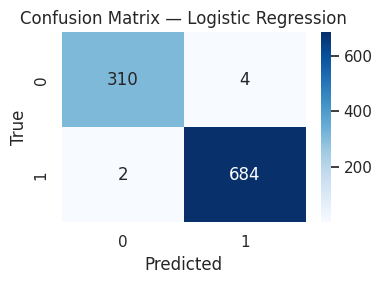

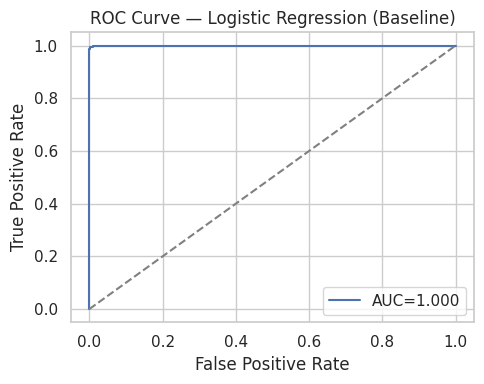

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Pipeline: preprocess + model
logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit
logit.fit(X_train, y_train)

# Predict & score
y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:,1]

acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Accuracy:  {acc:.3f}")
print(f"ROC-AUC:   {auc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1:        {f1:.3f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression (Baseline)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


## Insights & Next Steps

**Key EDA takeaways**
- Outcome rates vary by **activity_level**, **glp1_use**, and **stress_level**.
- Numeric drivers include **BMI**, **sleep_hours**, and **weekly_checkins** (per correlation and distributions).

**Baseline model (Logistic Regression)**
- Reported metrics (Accuracy, ROC-AUC, Precision, Recall, F1) provide a fair first benchmark.
- Next module will compare tree-based models (Random Forest/Gradient Boosting) and calibrate probabilities.

**Business interpretation (Skinii®)**
- Prioritize members with high activity, consistent GLP-1 use, better sleep, and lower stress for “fast-win” coaching.
- Use predicted probabilities to segment cohorts and tailor check-ins, content, and product bundles.

**Next steps**
1) Add cost-sensitive thresholding aligned to coaching capacity.  
2) Engineer interaction terms (e.g., GLP-1 × activity) and recency features.  
3) Evaluate SHAP for interpretability and create a non-technical executive brief.


In [11]:
from google.colab import files
files.download("skinii_health_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>